## Notebook setup

In [4]:

%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
import matplotlib.style as style
style.use('seaborn')

from sim_model import SimModel
from multisim_model import MultisimModel
from netgens import *
import networkx as nx

# must come after other imports to override standard tqdm
from tqdm.notebook import tqdm
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simple simulation

Simple simulation running on a small ER network.

In [11]:
INFECTED_P = 0.05
INFECTION_P = 0.02
RECOVERY_T = 14
RECOVERY_W = 5

G = nx.barabasi_albert_graph(10000, 20)
FREQ_DIST = 'uniform'

N_DAYS = 12
N_SIMS = 100
SHARE_INIT = True
ANALYSIS_DAY = 4

In [12]:
np.random.seed(20)

edge_gen = edge_gen_from_nx(G, N_DAYS, freq_dist=FREQ_DIST)
model = MultisimModel(len(G), edge_gen, INFECTED_P, INFECTION_P, 
                      RECOVERY_T, RECOVERY_W, N_DAYS, N_SIMS, 
                      share_init=SHARE_INIT, analysis_day=ANALYSIS_DAY, tqdm=tqdm)
t1s = time.time()
model.run_sim()
t1 = time.time() - t1s
print("time taken: ",t1)

Day: 11
time taken:  22.99284839630127


In [64]:
np.all(modelc.S == model.S)

True

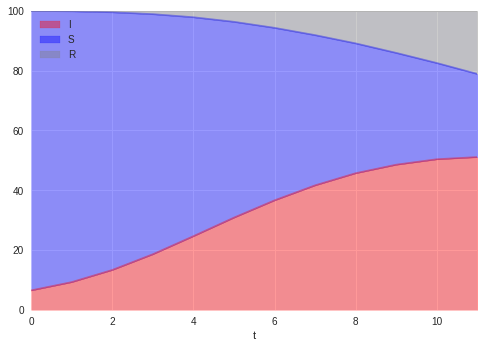

In [50]:
model.plot_stats()

In [6]:
import multisim_fast as my_multi

In [52]:
import time

Simulation stats through time look exactly as expected. ER network has randomly and independently distributed edges making the process look like the usual differential SIR analysis.

In [13]:
np.random.seed(20)

edge_gen2 = edge_gen_from_nx(G, N_DAYS, freq_dist=FREQ_DIST)
model2 = my_multi.MyMultisimModel(len(G), edge_gen2, INFECTED_P, INFECTION_P, 
                      RECOVERY_T, RECOVERY_W, N_DAYS, N_SIMS, 
                      share_init=SHARE_INIT, analysis_day=ANALYSIS_DAY, tqdm=tqdm)
t2_s = time.time()
model2.run_sim()
t2 = time.time() - t2_s
print("time taken: ",t2)

Day: 11
time taken:  4.821273326873779


In [14]:
print("Took {:.2%} time".format((t2-t1)/t1))

Took -79.03% time


In [55]:
np.all(model2.S == model.S)

True

In [56]:
np.all(model2.I == model.I)

True

Direct contact performance
              Not notified  Notified
Not infected          3705      3694
Infected               660      1466

Simulation performance (for non-direct contact nodes) if top 10% nodes are notified
              Not notified  Notified
Not infected          3378       327
Infected               535       125


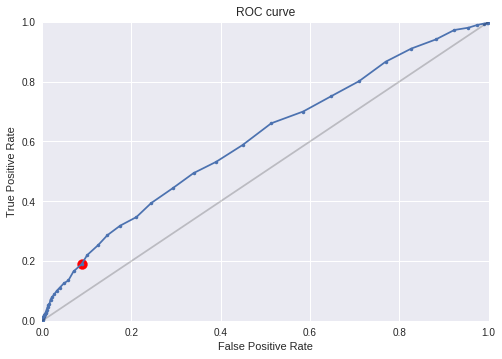

In [46]:
model.performance_analysis()

As expected, multi-step spread model doesn't perform well on ER and similar low-clustering networks with short average paths, because most of the network is already in the first neighborhood of someone infected. Second and other neigghborhoods mostly contain the whole network, making any models on those ranges look more-or-less like random guess.

However, it is a good example to showcase one feature of our models: manual score threshold setting. by default, all nodes in top 50% of the scores (excluding direct neighbors of initially infected nodes, and the infected nodes themselves) are notified (e.g. "predicted infected"). If we change this threshold, we can move along the ROC curve and analyze different confusion matrices. For example, setting the threshold to top 40%:

Direct contact performance
              Not notified  Notified
Not infected           155       511
Infected                43       230

Simulation performance (for non-direct contact nodes) if top 40% nodes are notified
              Not notified  Notified
Not infected            93        62
Infected                23        20


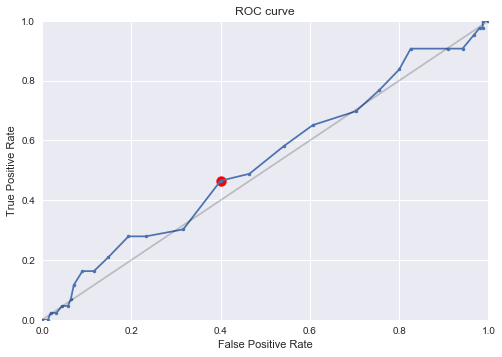

In [112]:
model.performance_analysis(notify_top_p=0.4)

For comparison, we can look at how different edge frequency distributions change the results. Using `bibeta` instead of `uniform`, we get better results as network is less connected.

First, let's visualize what the distribution looks like:

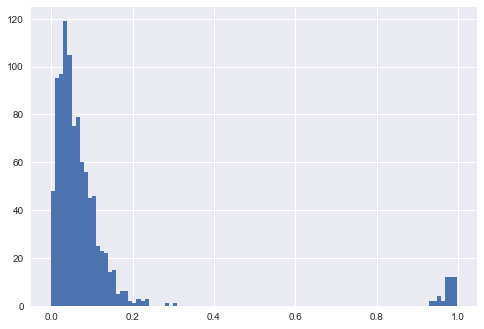

In [113]:
visualize_freq_dist('bibeta')

As explained in the introduction, most of the edges are highly infrequent (in the <10% range), and some are highly frequent (>90%).

In [150]:
INFECTED_P = 0.05
INFECTION_P = 0.02
RECOVERY_T = 14
RECOVERY_W = 5

G = nx.erdos_renyi_graph(1000, 0.05)
FREQ_DIST = 'bibeta'    # <- changed parameter

N_DAYS = 40
N_SIMS = 100
SHARE_INIT = True
ANALYSIS_DAY = 4

edge_gen = edge_gen_from_nx(G, N_DAYS, freq_dist=FREQ_DIST)
model = MultisimModel(len(G), edge_gen, INFECTED_P, INFECTION_P, 
                      RECOVERY_T, RECOVERY_W, N_DAYS, N_SIMS, 
                      share_init=SHARE_INIT, analysis_day=ANALYSIS_DAY, tqdm=tqdm)
model.run_sim()

No more infected nodes in any simulation, terminating on day 35.



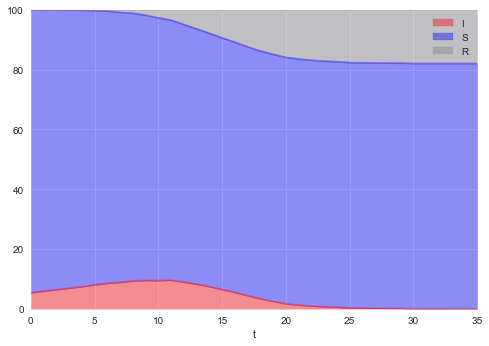

In [151]:
model.plot_stats()

Much fewer nodes are infected this time, as network is less connected. However, results are still not promising, and network is not clustered/compartmenalized in any way:

Direct contact performance
              Not notified  Notified
Not infected           737       179
Infected                12        23

Simulation performance (for non-direct contact nodes) if top 50% nodes are notified
              Not notified  Notified
Not infected           300       437
Infected                 2        10


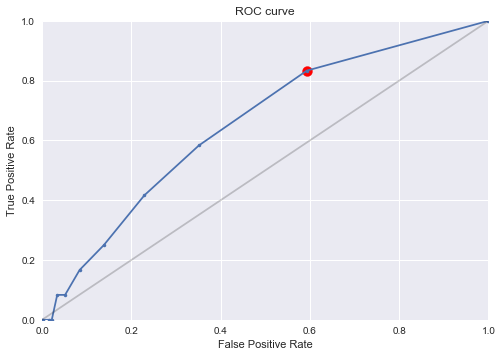

In [153]:
model.performance_analysis(0.5)

If confused by a seemingly great ROC curve, I suggest reading this: https://classeval.wordpress.com/simulation-analysis/roc-and-precision-recall-with-imbalanced-datasets/

##  Ring of cliques

Simple simulation based on the "ring of cliques" network. Ring of cliques is a network generated from K N-sized cliques (complete graphs) which are then connected into a ring (see [1] for an illustration).

This model, although higly unnatural, shows how the model behaves when the network is extremely compartmentalized.


[1] https://i.stack.imgur.com/6PW74.jpg

In [114]:
INFECTED_P = 0.05
INFECTION_P = 0.7    # Increasing the transmission probability because network is much less connected
RECOVERY_T = 14
RECOVERY_W = 5

G = nx.ring_of_cliques(1000, 5)   # 1000 cliques, each with 5 nodes
FREQ_DIST = 'bibeta'

N_DAYS = 40
N_SIMS = 100
SHARE_INIT = True
ANALYSIS_DAY = 4

edge_gen = edge_gen_from_nx(G, N_DAYS, freq_dist=FREQ_DIST)
model = MultisimModel(len(G), edge_gen, INFECTED_P, INFECTION_P, 
                      RECOVERY_T, RECOVERY_W, N_DAYS, N_SIMS, 
                      share_init=SHARE_INIT, analysis_day=ANALYSIS_DAY, tqdm=tqdm)
model.run_sim()

No more infected nodes in any simulation, terminating on day 35.



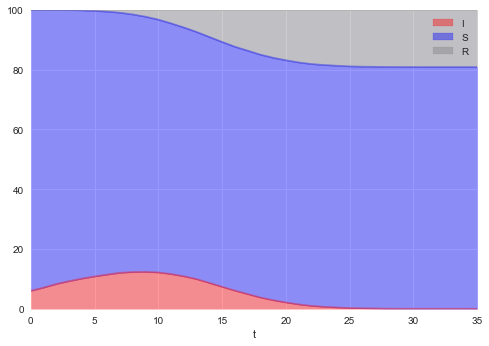

In [115]:
model.plot_stats()

Direct contact performance
              Not notified  Notified
Not infected          4469        12
Infected               218        86

Simulation performance (for non-direct contact nodes) if top 6% nodes are notified
              Not notified  Notified
Not infected          4395        74
Infected                 9       209


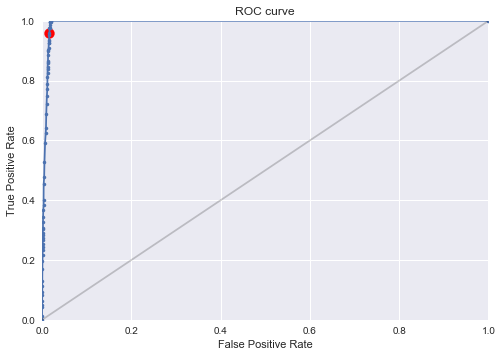

In [119]:
model.performance_analysis(0.06)

This is a strong evidence of the benefits of multi-step risk propagation in compartmenalized networks. As visible in the stats above, when top 8% of users (only considering those who haven't reported an infection and haven't been in close contact with the infected) are notified, ~250 of them really are infected, with only 120 getting false alerts. In comparison, direct-contact notifications only notified 110 infected people, although the false positive numbers are much lower (20 users).

##  Barabási–Albert

Similarly to ER, BA networks aren't clustered nor compartmenalized enough to model real work interactions. However, as this is an extremely popular model, we're analyzing it for completeness.

For detailed explanation of the model, see: https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model

In [120]:
INFECTED_P = 0.05
INFECTION_P = 0.05
RECOVERY_T = 14
RECOVERY_W = 5

G = nx.barabasi_albert_graph(100_000, 100)
FREQ_DIST = 'bibeta'

N_DAYS = 6
N_SIMS = 100
SHARE_INIT = True
ANALYSIS_DAY = 5

edge_gen = edge_gen_from_nx(G, N_DAYS, freq_dist=FREQ_DIST)
model = MultisimModel(len(G), edge_gen, INFECTED_P, INFECTION_P, 
                      RECOVERY_T, RECOVERY_W, N_DAYS, N_SIMS, 
                      share_init=SHARE_INIT, analysis_day=ANALYSIS_DAY, tqdm=tqdm)
model.run_sim()

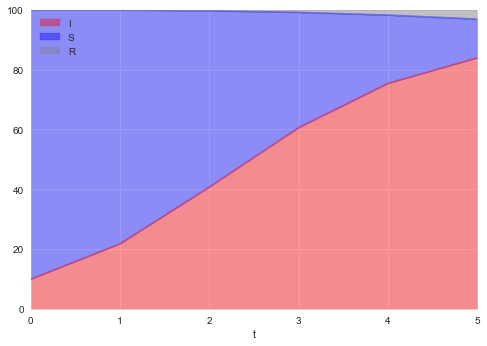

In [121]:
model.plot_stats()

Direct contact performance
              Not notified  Notified
Not infected          7076      5723
Infected             32287     49856

Simulation performance (for non-direct contact nodes) if top 30% nodes are notified
              Not notified  Notified
Not infected          5966      1110
Infected             20252     12035


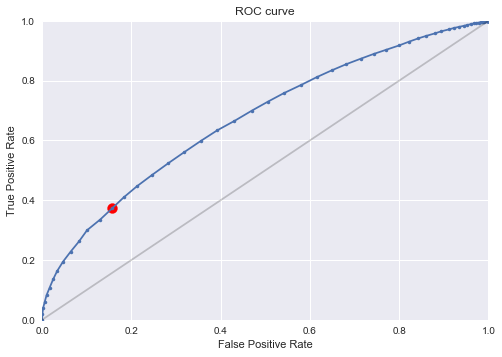

In [125]:
model.performance_analysis(0.3)

Although not a compartmenalized network, our appproach shows surprisingly good performance on BA networks.

## Influence of parameter errors on risk estimates

We will first create and run a new simulations, similar to the previous one. Then, we will take a single simulation instance out of that run as our "ground truth" - as a "reality" that happened and that we want to predict.

Next, we will create a new model with significantly different parameters, and see how well it predicts the "reality" we created.

Both runs share the same interactions and initial infections.

In [143]:
INFECTED_P = 0.05
INFECTION_P = 0.05
RECOVERY_T = 14
RECOVERY_W = 5

G = nx.barabasi_albert_graph(10_000, 100)
FREQ_DIST = 'bibeta'

N_DAYS = 6
N_SIMS = 100
SHARE_INIT = True
ANALYSIS_DAY = 5

edge_gen_list = list(edge_gen_from_nx(G, N_DAYS, freq_dist=FREQ_DIST))
model = MultisimModel(len(G), edge_gen_list, INFECTED_P, INFECTION_P, 
                      RECOVERY_T, RECOVERY_W, N_DAYS, N_SIMS, 
                      share_init=SHARE_INIT, analysis_day=ANALYSIS_DAY, tqdm=tqdm)
model.run_sim()

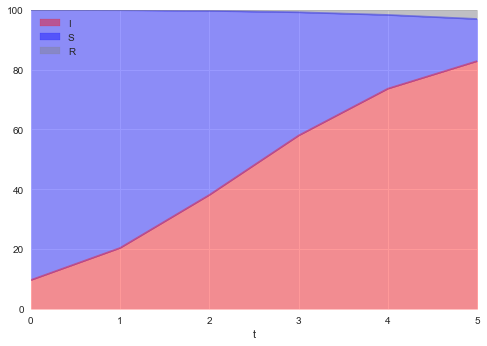

In [144]:
model.plot_stats()

Direct contact performance
              Not notified  Notified
Not infected           750       625
Infected              3078      5071

Simulation performance (for non-direct contact nodes) if top 40% nodes are notified
              Not notified  Notified
Not infected           572       178
Infected              1623      1455


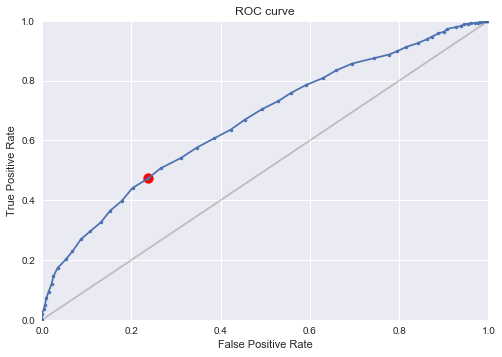

In [145]:
model.performance_analysis(0.4)

Infection probability will now be 5x lower, and recovery time 2x shorter, making this a much less spreadable contagion.

In [146]:
INFECTION_P = 0.01
RECOVERY_T = 7

model2 = MultisimModel(len(G), edge_gen_list, INFECTED_P, INFECTION_P, 
                       RECOVERY_T, RECOVERY_W, N_DAYS, N_SIMS, 
                       share_init=SHARE_INIT, initial_infected=model.initial_infected,
                       analysis_day=ANALYSIS_DAY, analysis_true_I=model.analysis_true_I,
                       tqdm=tqdm)
model2.run_sim()

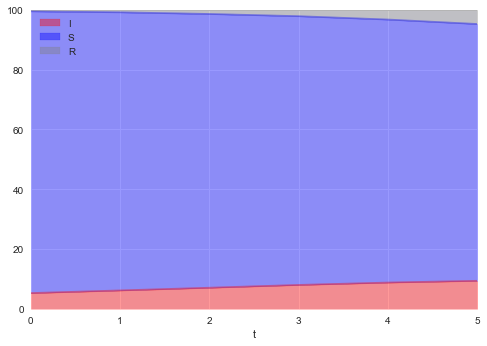

In [147]:
model2.plot_stats()

As expected, only ~15% nodes got infected this time, compared to 85% that were infected in the original run. However, as we can see below, predictive power of such "wrong" model hasn't decreased.

Direct contact performance
              Not notified  Notified
Not infected           750       625
Infected              3078      5071

Simulation performance (for non-direct contact nodes) if top 40% nodes are notified
              Not notified  Notified
Not infected           497       253
Infected              1629      1449


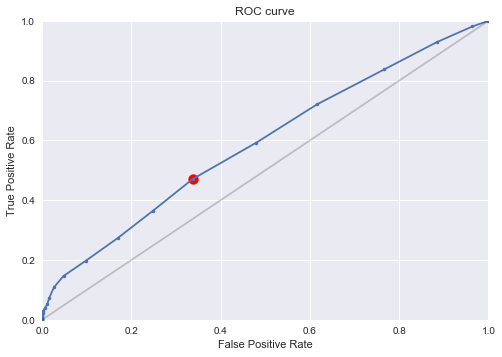

In [148]:
model2.performance_analysis(0.4)

## Influence of noise

By introducing random noise in terms of randomly emerging infection cases (some percent of nodes each day) we easily model user sparsity and interaction detection defects.

In [131]:
INFECTED_P = 0.05
INFECTION_P = 0.05
RECOVERY_T = 14
RECOVERY_W = 5

G = nx.barabasi_albert_graph(10_000, 100)
FREQ_DIST = 'bibeta'

N_DAYS = 6
N_SIMS = 100
SHARE_INIT = True
ANALYSIS_DAY = 5

NOISE = 0.01

edge_gen_list = list(edge_gen_from_nx(G, N_DAYS, freq_dist=FREQ_DIST))
model = MultisimModel(len(G), edge_gen_list, INFECTED_P, INFECTION_P, 
                      RECOVERY_T, RECOVERY_W, N_DAYS, N_SIMS, noise=NOISE,
                      share_init=SHARE_INIT, analysis_day=ANALYSIS_DAY, tqdm=tqdm)
model.run_sim()

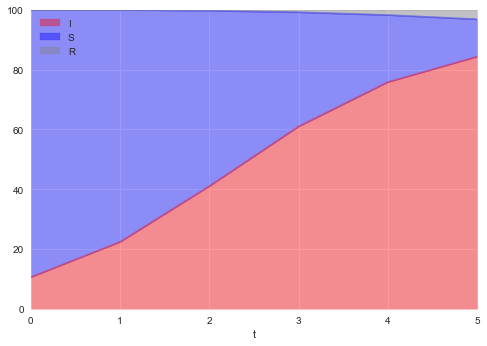

In [132]:
model.plot_stats()

Direct contact performance
              Not notified  Notified
Not infected           672       530
Infected              3388      4911

Simulation performance (for non-direct contact nodes) if top 40% nodes are notified
              Not notified  Notified
Not infected           541       131
Infected              1845      1543


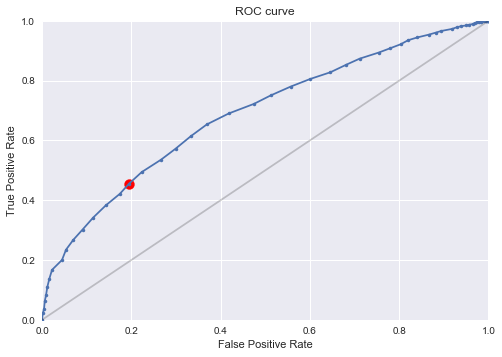

In [133]:
model.performance_analysis(0.4)

Finally, comparing the predictions with wrong parameters when noise is present.

In [134]:
INFECTION_P = 0.01
RECOVERY_T = 7

model2 = MultisimModel(len(G), edge_gen_list, INFECTED_P, INFECTION_P, 
                       RECOVERY_T, RECOVERY_W, N_DAYS, N_SIMS, 
                       share_init=SHARE_INIT, initial_infected=model.initial_infected,
                       analysis_day=ANALYSIS_DAY, analysis_true_I=model.analysis_true_I,
                       tqdm=tqdm)
model2.run_sim()

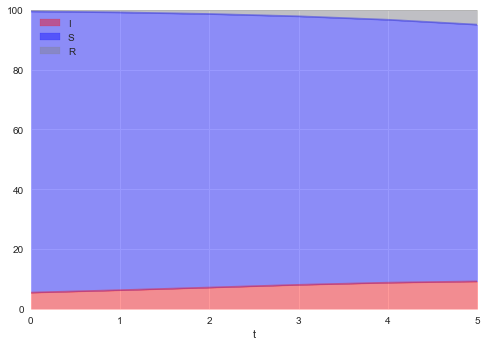

In [135]:
model2.plot_stats()

Direct contact performance
              Not notified  Notified
Not infected           672       530
Infected              3388      4911

Simulation performance (for non-direct contact nodes) if top 40% nodes are notified
              Not notified  Notified
Not infected           466       206
Infected              1922      1466


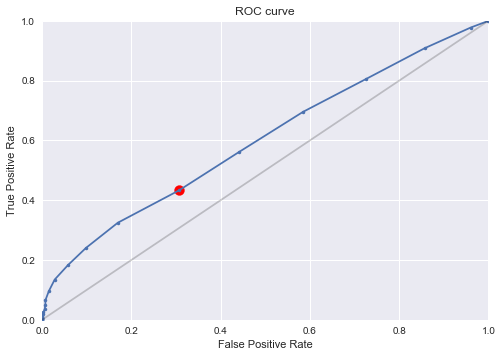

In [136]:
model2.performance_analysis(0.4)